In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, struct

In [2]:
from utils.latticeeasy import *
from utils.extract_utils import shift_volume
from utils.gmon import get_mass
from utils.extract_utils import interpolate

# Load data

In [3]:
output_dir = "/media/yangelaxue/TRANSFER/Colliding_Oscillons/alpha_beta-0.5_50_250.804626/osc2_128_v2"

data = LATTICEEASY(output_dir)
data.__dict__

{'output_dir': '/media/yangelaxue/TRANSFER/Colliding_Oscillons/alpha_beta-0.5_50_250.804626/osc2_128_v2',
 'alpha': 0.5,
 'beta': 50.0,
 'phi_0': 0.118201,
 'dt_pr': 0.001,
 'domain_width_pr': array([0.365995, 0.365995, 0.365995]),
 'domain_dimensions': (128, 128, 128),
 't': array([ 13.001625,  38.9902  ,  64.975914,  90.961632, 116.94735 ,
        129.955017, 130.000336]),
 '_slice_tidx': array([0, 1, 2, 3, 4, 5, 6]),
 'a': array([10.73867, 10.73867, 10.73867, 10.73867, 10.73867, 10.73867,
        10.73867]),
 'ap': array([0., 0., 0., 0., 0., 0., 0.]),
 'app': array([0., 0., 0., 0., 0., 0., 0.]),
 'rescale_A': 8.46016531163019,
 'rescale_B': 4.067346132288118e-06,
 'rescale_r': 2.0,
 'rescale_s': 1.0}

In [4]:
timeslice = 6
data.t[timeslice]

130.000336

In [5]:
phi = load_phi(output_dir,data.domain_dimensions,timeslice)
phip = load_phip(output_dir,data.domain_dimensions,timeslice)
Edens = data.get_Edens_pr(timeslice)

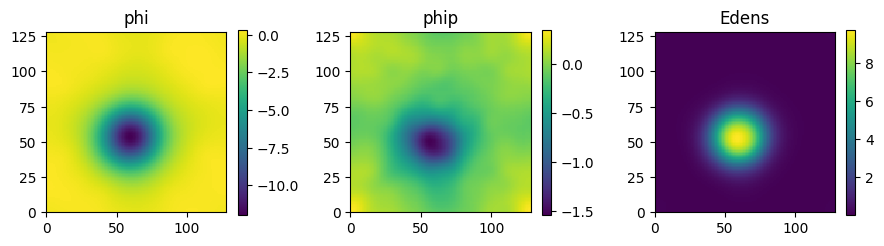

In [6]:
vals = [phi[:,64].T, phip[:,64].T, Edens[:,64].T]
titles = ["phi", "phip", "Edens"]

fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)

for i, ax in enumerate(axes):
    
    im = ax.pcolormesh(vals[i])
    ax.set_aspect('equal')
    ax.set_title(titles[i])
    
    fig.colorbar(im,shrink=.5)

# Interpolate

In [7]:
shape_i = (128,128,128)

if shape_i==data.domain_dimensions:
    print("No interpolation")
else:
    phi_i, phip_i = interpolate(shape_i,phi,phip)

No interpolation


# Shift to centre

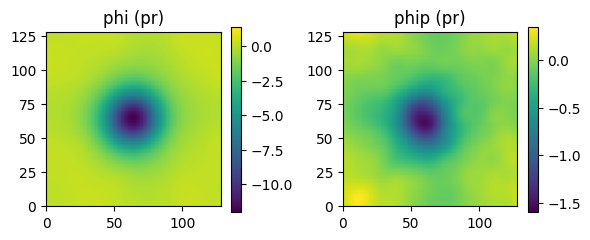

In [8]:
if 1:
    center = tuple(np.round(np.array([(Edens*x).sum() for x in np.indices(shape_i)])/Edens.sum()).astype(int))

    phi_sh, phip_sh, Edens_sh = shift_volume(center, phi, phip, Edens)
    
    cross = shape_i[0]//2

    fig, axes = plt.subplots(1,2,figsize=(6,4),tight_layout=True)

    for ax in axes:
        ax.set_aspect('equal')

    mesh = axes[0].pcolormesh(phi_sh[:,cross],
                  vmin=phi.min(), vmax=phi.max(),
                  )
    axes[0].set_title("phi (pr)")
    fig.colorbar(mesh,shrink=.5)

    mesh = axes[1].pcolormesh(phip_sh[:,cross],
                  vmin=phip.min(), vmax=phip.max(),
                  )
    axes[1].set_title("phip (pr)")
    fig.colorbar(mesh,shrink=.5)
else:
    phi_sh, phip_sh, Edens_sh = phi, phip, Edens

# Save as .img

In [9]:
# dt_pr = data.dt_pr
dt_pr = 0.001

dt_pr, data.dt_pr, dt_pr/(data.domain_width_pr/shape_i)

(0.001, 0.001, array([0.34973155, 0.34973155, 0.34973155]))

In [11]:
phi_sh_adv = phi_sh + dt_pr/2*phip_sh

In [14]:
N = shape_i[0]
n_points = N*N*N

fname_o = f"highres_time_{N}.img"
datname_o = f"highres_time_{N}.dat"
fdir = f"highres_time_{N}"

if not os.path.exists(os.path.join(output_dir, fdir)):
    os.makedirs(os.path.join(output_dir, fdir))

with open(os.path.join(output_dir, fdir, datname_o), 'w') as dat:
    dat.write(f"N = {phi_sh_adv.shape}\n")
    dat.write(f"L_pr = {data.domain_width_pr}\n")
    dat.write(f"dt_pr = {dt_pr}\n")
    dat.write(f"alpha = {data.alpha}\n")
    dat.write(f"beta = {data.beta}\n")
    dat.write(f"f0 = {data.phi_0}\n")
    dat.write(f"\n")
    
    dat.write(f"Spatial resolution change {data.domain_dimensions} -> {shape_i}\n")
    dat.write(f"Temporal resolution change {data.dt_pr} -> {dt_pr}\n")
    dat.write(f"Run simulations from t_pr = {data.t[timeslice]}\n")
    dat.write(f"output_dir = {os.path.join(output_dir, fdir)}\n")
    
with open(os.path.join(output_dir, fdir, fname_o),'wb') as f_o:
    
    f_o.write(struct.pack('<i',-1))
#     f_o.write(struct.pack('<f',data.t[timeslice]))
    f_o.write(struct.pack('<f',0))
    f_o.write(struct.pack('<f',data.a[timeslice]))
    f_o.write(struct.pack('<f',data.ap[timeslice]))
    
    f_o.write(struct.pack('<'+'f'*n_points,*phi_sh_adv.flatten()))
    f_o.write(struct.pack('<'+'f'*n_points,*phip_sh.flatten()))

In [13]:
mass = get_mass(data.alpha,data.beta)

omega_pr = mass/(data.rescale_B*data.a[timeslice]**data.rescale_s)
T_pr = 2*np.pi/omega_pr

T_pr

12.395807480182734

In [19]:
(800-225)

575